In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

data = pd.read_csv('/root/autodl-tmp/统计建模/data/data with AE(latent dim=6).csv')
X = data.drop(columns=['Diagnosis']).values
y = data['Diagnosis'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 转换为PyTorch张量
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# 创建数据集和数据加载器
batch_size = 256
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

<span style="font-size:20px">网络

In [4]:
class MLP(nn.Module):
    def __init__(self, input_size):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size,32)
        self.fc2 = nn.Linear(32, 64)
        self.fc3 = nn.Linear(64, 128)
        self.fc4 = nn.Linear(128, 2)

        self.relu = nn.ReLU()
        self.norm1= nn.BatchNorm1d(32)
        self.norm2= nn.BatchNorm1d(64)
        self.norm3= nn.BatchNorm1d(128)
        self.norm4= nn.BatchNorm1d(2)
        self.softmax = nn.Softmax(dim=1)
        
        self.Dropout =  nn.Dropout(0.2)
        
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.norm1(x)
        x = self.relu(x)
        
        x = self.Dropout(x)
        
        x = self.fc2(x)
        x = self.norm2(x)
        x = self.relu(x)
        
        x = self.Dropout(x)
           
        x = self.fc3(x)
        x = self.norm3(x)
        x = self.relu(x)
        
        x = self.Dropout(x)
        
        x = self.fc4(x)
        x = self.norm4(x)
        x = self.relu(x)
        
        # x = self.Dropout(x)
        
        # x = self.fc5(x)
        
        return self.softmax(x)

In [5]:
# 初始化模型、损失函数和优化器
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MLP(X.shape[1]).to(device)
criterion = nn.CrossEntropyLoss()      
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 训练参数
num_epochs = 50
train_losses = []
test_losses = []

# 训练循环
for epoch in range(num_epochs):
    # 训练阶段
    model.train()
    epoch_train_loss = 0
    for data, labels in train_loader:
        data = data.to(device)
        labels = labels.to(device)
        # 前向传播
        outputs = model(data)
        loss = criterion(outputs, labels)
        
        # 反向传播
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_train_loss += loss.item() * data.size(0)
    
    # 记录训练损失
    train_loss = epoch_train_loss / len(train_loader.dataset)
    train_losses.append(train_loss)
    
    # 验证阶段
    model.eval()
    epoch_test_loss = 0
    with torch.no_grad():
        for data, labels in test_loader:
            data = data.to(device)
            labels = labels.to(device)
            outputs = model(data)
            loss = criterion(outputs, labels)
            epoch_test_loss += loss.item() * data.size(0)
    
    # 记录验证损失
    test_loss = epoch_test_loss / len(test_loader.dataset)
    test_losses.append(test_loss)
    
    # 打印训练进度
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}')

Epoch [10/50], Train Loss: 0.4870, Test Loss: 0.4893
Epoch [20/50], Train Loss: 0.4851, Test Loss: 0.4878
Epoch [30/50], Train Loss: 0.4850, Test Loss: 0.4878
Epoch [40/50], Train Loss: 0.4850, Test Loss: 0.4877
Epoch [50/50], Train Loss: 0.4850, Test Loss: 0.4878


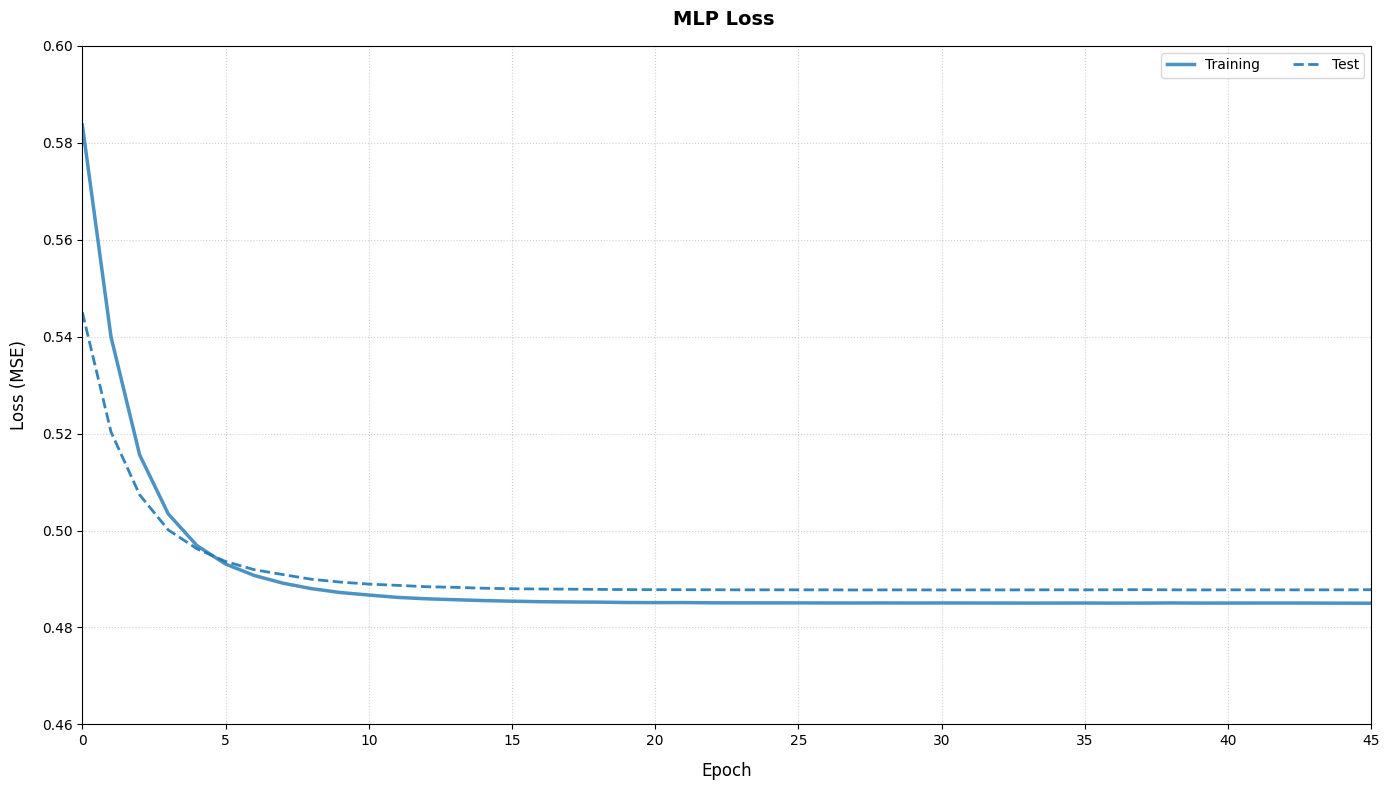

In [7]:
plt.style.use('default')
# 平滑处理（保持原有函数不变）
def smooth_curve(losses, alpha=0.2):
    smoothed = [losses[0]]
    for loss in losses[1:]:
        smoothed.append(alpha * smoothed[-1] + (1 - alpha) * loss)
    return smoothed

# 创建画布（单图）
plt.figure(figsize=(14, 8), dpi=100)

# ===== 维度2 =====
# 训练损失（蓝色实线）
smooth_train = smooth_curve(train_losses, alpha=0.2)
plt.plot(smooth_train, 
         label='Training ', 
         color='#1f77b4',   # 标准蓝
         linewidth=2.5,
         alpha=0.8)

# 测试损失（蓝色虚线）
smooth_test= smooth_curve(test_losses, alpha=0.1)
plt.plot(smooth_test,
         label='Test', 
         color='#1f77b4',
         linestyle='--',    # 虚线
         linewidth=2,
         alpha=0.9)

# ===== 图表美化 =====
# 坐标轴设置
plt.xlabel('Epoch', fontsize=12, labelpad=10)
plt.ylabel('Loss (MSE)', fontsize=12, labelpad=10)
plt.title('MLP Loss ', 
          fontsize=14, pad=15, fontweight='bold')

# 范围与刻度
plt.xlim(0, 20)
plt.ylim(0.46, 0.6)
plt.xticks(np.arange(0, 50, 5))  # 每2个epoch显示刻度

# 图例与网格
plt.legend(loc='upper right', 
           frameon=True,
           fontsize=10,
           ncol=3)  # 双列布局
plt.grid(True, linestyle=':', alpha=0.6)

# 显示图表
plt.tight_layout()
plt.show()

In [8]:
# Evaluate model
model.eval()
y_pred = []
y_true = []
with torch.no_grad():
    X_test_tensor=X_test_tensor.to(device)
    outputs = model(X_test_tensor)
    _, predicted = torch.max(outputs, 1)
    y_pred.extend(predicted.cpu().numpy())
    y_true.extend(y_test_tensor.cpu().numpy())

In [9]:
outputs[:,1].cpu().numpy()

array([1.5889183e-05, 9.4872838e-01, 1.7254988e-05, ..., 1.5817639e-05,
       1.5412335e-05, 1.5259429e-05], dtype=float32)

In [10]:
# Classification Report
from sklearn.metrics import classification_report
print('Classification Report:')
print(classification_report(y_true, y_pred, target_names=['Benign', 'Malignant'],digits=4))

Classification Report:
              precision    recall  f1-score   support

      Benign     0.8483    0.9400    0.8918     32615
   Malignant     0.6940    0.4474    0.5441      9924

    accuracy                         0.8251     42539
   macro avg     0.7711    0.6937    0.7179     42539
weighted avg     0.8123    0.8251    0.8106     42539



In [11]:
#训练集精度
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
X_train_tensor=X_train_tensor.to(device)
accuracy_score( y_train_tensor.cpu().numpy(), torch.max(model(X_train_tensor), 1)[1].cpu().numpy() )

0.8279303211246415

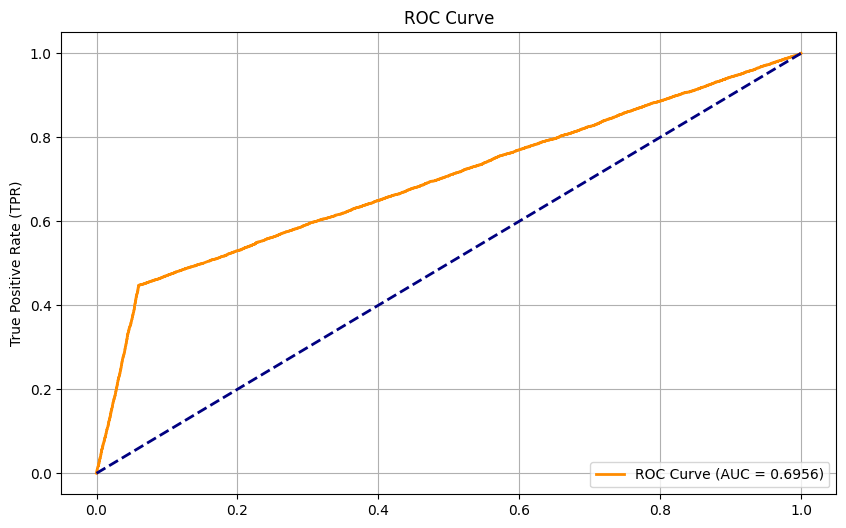

In [71]:
from sklearn.metrics import roc_curve, roc_auc_score
y_score=outputs[:,1].cpu().numpy()
# 计算ROC曲线和AUC
fpr, tpr, thresholds = roc_curve(y_true, y_score,pos_label=1)
roc_auc = roc_auc_score(y_true, y_score)
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

In [72]:
from sklearn.metrics import classification_report
#保存预测值，为后续画图
# 将y_score转为DataFrame并自定义列名
combined_df = pd.DataFrame({
    'MLP': y_score
})
combined_df.to_csv('MLP.csv', index=False)